In [1]:
import math
import time
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.analysis import ActiveSubspace

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin

# Figure 3

In [2]:
pd.options.display.max_columns = 999

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_MECH_KD_A = "../svg/panel_mech_kd_a_new.svg"
PANEL_MECH_KD_B = "../svg/panel_mech_kd_b_new.svg"
PANEL_MECH_KD_C = "../svg/panel_mech_kd_c_new.svg"
PANEL_MECH_KD_D = "../svg/panel_mech_kd_d_new.svg"
PANEL_MECH_KD_E = "../svg/panel_mech_kd_e_new.svg"
PANEL_MECH_KD_F = "../svg/panel_mech_kd_f_new.svg"
PANEL_MECH_KD_voltage = "../svg/panel_mech_kd_voltage_new.svg"

### Load experimental data

In [5]:
prior_11 = create_prior()

In [6]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

### Time vector

In [7]:
t = np.arange(0, 11000, 0.025)

### Doubling Na leads to twice as high effective conductances

In [8]:
from pyloric.utils import show_traces

In [9]:
custom_stats = {
    "plateau_durations": True,
    "num_bursts": True,
    "num_spikes": True,
    "energies": True,
    "energies_per_burst": True,
    "energies_per_spike": True,
    "pyloric_like": True,
}

In [10]:
index = 2

In [11]:
out_target_base = simulate(theta.loc[index], seed=int(seeds[index]), track_energy=True, track_currents=True)
summstats_base = summary_stats(out_target_base, stats_customization=custom_stats)

In [12]:
print("Energy consumption of PY:              ", int(summstats_base["energies"]["PY"].loc[0]))
print("Num spikes of PY:                      ", int(summstats_base["num_spikes"]["PY"].loc[0]))
print("Energy consumption per spike of PY:    ", int(summstats_base["energies_per_spike"]["PY"].loc[0]))

Energy consumption of PY:               30661
Num spikes of PY:                       162
Energy consumption per spike of PY:     185


### ...but doubling Kd does not

In [20]:
perturbed_theta = deepcopy(theta.loc[index])
perturbed_theta["PY"]["CaS"] += perturbed_theta["PY"]["CaS"] * 0.5

In [21]:
out_target = simulate(perturbed_theta, seed=int(seeds[index]), track_energy=True, track_currents=True)
summstats = summary_stats(out_target, stats_customization=custom_stats)

In [23]:
print("Energy consumption of PY:              ", int(summstats["energies"]["PY"].loc[0]))
print("Num spikes of PY:                      ", int(summstats["num_spikes"]["PY"].loc[0]))
print("Energy consumption per spike of PY:    ", int(summstats["energies_per_spike"]["PY"].loc[0]))

Energy consumption of PY:               47154
Num spikes of PY:                       223
Energy consumption per spike of PY:     204


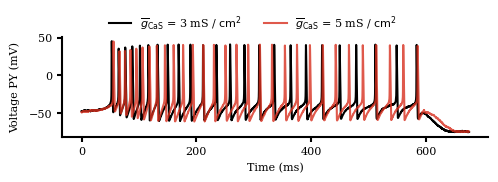

In [28]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 1.3))
    _ = ax.plot(t[:92500-65500], out_target_base["voltage"][2, 70000:97000], c="k")
    _ = ax.plot(t[:92500-65500], out_target["voltage"][2, 66500:93500], alpha=0.8, c="#d7301f")
    ax.set_ylabel("Voltage PY (mV)", labelpad=6.5)
    ax.set_xlabel("Time (ms)")
    ax.legend(
        [
            "$\overline{g}_{\mathrm{CaS}}$"+f" = {int(theta.loc[index]['PY']['CaS'])}" + " mS / $\mathrm{cm}^2$", 
            "$\overline{g}_{\mathrm{CaS}}$"+f" = {int(perturbed_theta['PY']['CaS'])}" + " mS / $\mathrm{cm}^2$"
        ], 
        loc=(.1, 1.), 
        labelspacing=0.3,
        ncol=2
    )
    
#     ax.set_ylim([-0.45, 11])
#     ax.set_yticks([0, 11])
    ax.set_xticks([0, 200, 400, 600])
    plt.savefig(PANEL_MECH_KD_A, facecolor="None", transparent=True)

In [29]:
[(summstats["num_spikes"]["PY"].to_numpy()/summstats["num_bursts"]["PY"].to_numpy()).tolist()[0]]

[27.875]

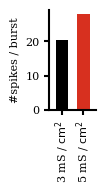

In [33]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.6, 1.3))
    _ = ax.bar(
        [0, 1], 
        [
            (summstats_base["num_spikes"]["PY"].to_numpy()/summstats_base["num_bursts"]["PY"].to_numpy()).tolist()[0], 
            (summstats["num_spikes"]["PY"].to_numpy()/summstats["num_bursts"]["PY"].to_numpy()).tolist()[0]
        ], 
        width=0.6,
        color=["k", "#d7301f"],
    )
    ax.set_xlim([-0.6, 1.6])
    ax.set_xticks([0, 1])
    ax.set_xticklabels([])
    ax.set_xticklabels(
        [
            f"{int(theta.loc[index]['PY']['CaS'])}" + " mS / $\mathrm{cm}^2$", 
            f"{int(perturbed_theta['PY']['CaS'])}" + " mS / $\mathrm{cm}^2$"
        ],
        rotation=90
    )
    ax.set_ylabel("#spikes / burst")
#     _ = ax.plot(t[:92500-65500], out_target["voltage"][2, 68300:95300], alpha=0.8, c="#d7301f")
#     ax.set_ylabel("Voltage PY (mV)", labelpad=6.5)
#     ax.set_xlabel("Time (ms)")
#     ax.legend(
#         [
#             "$\overline{g}_{\mathrm{CaT}}$"+f" = {int(theta.loc[index]['PY']['CaT'])}" + " mS / $\mathrm{cm}^2$", 
#             "$\overline{g}_{\mathrm{CaT}}$"+f" = {int(perturbed_theta['PY']['CaT'])}" + " mS / $\mathrm{cm}^2$"
#         ], 
#         loc=(.1, 1.), 
#         labelspacing=0.3,
#         ncol=2
#     )
    
# #     ax.set_ylim([-0.45, 11])
# #     ax.set_yticks([0, 11])
#     ax.set_xticks([0, 200, 400, 600])
    plt.savefig(PANEL_MECH_KD_C, facecolor="None", transparent=True)

In [34]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [35]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "4.9cm",
    Panel(
          SVG(PANEL_MECH_KD_A).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, -1.4*factor_svg),
    Panel(
          SVG(PANEL_MECH_KD_C).scale(svg_scale).move(0, 0*factor_svg),
    ).move(85*factor_svg, 2.0*factor_svg),
    
)

!mkdir -p fig
f.save("../fig/fig3_supp9.svg")
svg('../fig/fig3_supp9.svg')